
## STOCHASTIC MODELING
MODULE 6 | LESSON 4


---

# **k-ARMED BANDITS: Stock Price Case Study**

|  |  |
|:---|:---|
|**Reading Time** |  30 min |
|**Prior Knowledge** |Markov process, Optimization, Monte Carlo  |
|**Keywords** |Reinforcement learning, multi-armed bandits


---

*In this notebook, we describe additional fine-tuning techniques that can foster the exploration side of the learning algorithm. Lastly, we illustrate an application of the $k$-armed bandit to real data of stock prices.*

## **1. Fine-Tuning Techniques**

### **1.1 Optimistic Initial Values**

Initial action values can also be used as fine-tuning tool to encourage the exploration of actions. Rather than setting the initial action values to zero, we can set them to wildly optimistic values relative to our prior beliefs on the rewards. This optimism encourages the use of action-value methods to explore across the space of actions. While this may be of help in the stationary case, any method that focuses on the initial conditions is unlikely to help with the general nonstationary case.

### **1.2 Upper-Confidence Bound**

We need to induce some degree of exploration in the actions because we are always uncertain about our action-value estimates. The greedy actions are the currently optimal ones from a backward-looking perspective, but some of the other actions may be better without us actually knowing. However, $\varepsilon$-greedy action selection forces the non-greedy actions to be tried, but without a particular preference.

To overcome this, and prioritize the exploration of actions that we are more uncertain about, we can  follow the next optimal choice:
$$
\begin{equation}
A_t = \arg\underset{a}{\max} \left\{Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right\}
\end{equation}
$$
where the new term adjusts for the degree of "unexploration" of the action relative to the steps completed. The parameter $c>0$ controls the degree of exploration. If $N_t(a)=0$, $a$ is considered to be a maximizing action to avoid the ratio to be infinite. We will implement this procedure in the application to stock-picking strategies below.

### **1.3 Stochastic Gradient Ascent**

The methods above estimate action values and use those estimates to select actions deterministically. We can also opt for a stochastic selection. We consider learning a score or preference for each action a, which we denote $Y_t(a)$. The larger the score, the more often that action is taken, but the preference has no interpretation in terms of reward. Only the relative preference of one action over the others is important. The probabilities of taking each action arises from a soft-max distribution:
$$
\begin{equation}
\pi_t(a) = \frac{\exp(Y_t(a))}{\sum_{b\in\mathcal{A}}\exp(Y_t(b))}
\end{equation}
$$
Initially, all action preferences are the same (e.g., $Y_0(a) = 0$, for all $a$) so that all actions have an equal probability of being selected.

There is a natural learning algorithm for this setting based on the idea of stochastic gradient ascent. On each step, after selecting action $a_t$ and receiving the reward $r_t$, the action preferences are updated by:
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) + \alpha (r_t - \overline{r}_t) (1-\pi_t(a))\ if\ a=a_t
\end{equation}
$$
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) - \alpha (r_t - \overline{r}_t)\pi_t(a)\ if\ a\neq a_t
\end{equation}
$$
where $\alpha > 0$ is a step-size parameter as introduced above, and $\overline{r}_t$ is the average of all the rewards up through and including time t.

This method embeds the $\varepsilon$-greedy action choice allowing for time-varying probability of action selection according to past experience. However, stochastic gradient descent is prone to generate similar issues as averaging in the case of non-stationary data. This issue arises because the choice of action depends on the estimated scores, which are less sensitive to changes in the rewards of the actions after the agent has gone through decisions in many time steps.

## **2. A Stock-Picking Problem**

As an investor, you face the problem of picking one stock among a pre-selection of 5 stocks. Every day, you are going to purchase shares of a given stock and hold it for one trading day. Suppose that you have unlimited funding or at least enough to make any of the required trades in this exercise. 

You are going to consider this situation as a 5-bandit problem, where we want to learn which stock yields on average the greatest profit over the holding period. Notice that a stock-picking problem is a non-stationary problem by nature, since investors' expectations and sentiment about particular stocks change over time. Moreover, contrary to the examples from previous lessons, we have lost control of the data-generation process; it is a given to us.

We first load the data and some additional libraries.

In [6]:
# Read stock price information

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import rand, seed


def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new


tickers = ["AAPL", "AMZN", "MSFT", "NVDA", "TWTR"]
stock = 0
for tick in tickers:  # noQA E203
    # Read data
    PData = pd.read_csv(f"data/{tick}.csv")
    if stock == 0:  # noQA E203
        df0 = PData[["Adj Close"]]
    else:
        df0 = pd.concat([df0, PData[["Adj Close"]]], axis=1)
    stock += 1
YData = df0.to_numpy()
YData_dates = pd.to_datetime(PData["Date"], format="%Y-%m-%d")

In [7]:
YData


array([[ 36.148441,  51.9935  ,  69.490341,  40.878643,  19.969999],
       [ 36.318848,  52.639999,  69.359222,  41.350849,  19.610001],
       [ 35.632515,  52.299999,  68.525581,  39.986168,  16.84    ],
       ...,
       [153.039993, 122.769997, 262.269989, 178.070007,  39.599998],
       [155.350006, 124.629997, 264.839996, 180.5     ,  39.52    ],
       [154.089996, 122.419998, 260.359985, 173.190002,  39.84    ]],
      shape=(1258, 5))

Now we visualize the cumulative performance of each stock during the sample period.

The sample period covers 25 Jul 2017 to 22 Jul 2022


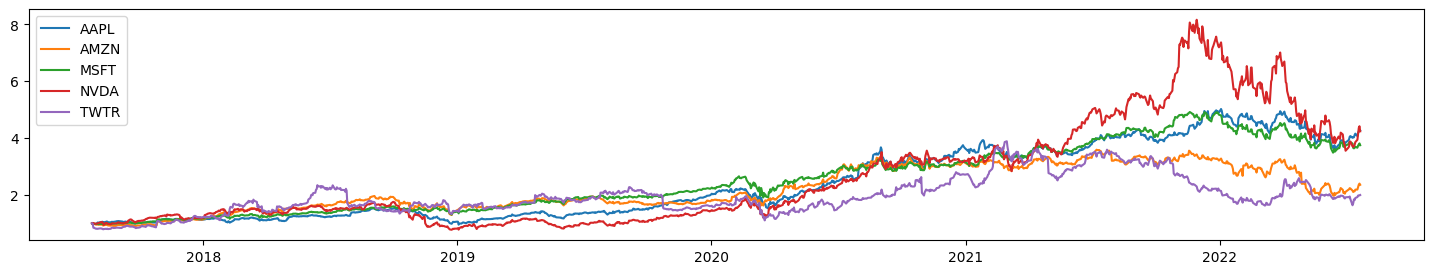

In [8]:
print(
    "The sample period covers {:%d %b %Y} to {:%d %b %Y}".format(
        YData_dates[0], YData_dates[YData_dates.shape[0] - 1]
    )
)

plt.plot(YData_dates, YData / YData[0, :])  # noQA E203
plt.legend(tickers)

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

Now we run the $k$-armed bandit algorithm as in the previous examples of this module. As it becomes clear below, the non-stationary nature of the data calls for less exploration and quick adjustment to new data. Thus, we choose parameters $\varepsilon=0.1$ and $\alpha=0.975$.

In every time step, we update the action-value function, while the actual stock picked depends also on its lack of exploration. The code is general enough to allow for holding periods longer than one day. For this, we need to maintain a record of the past history of choices and rewards. We make trading decisions, but rewards of the actions are only known at some later period rather than immediately.

In [9]:
# Bandit problem for stock selection

NK = 5
EPSILON = 0.1
ALPHA = 0.975
NEPISODES = 1000
HOLD = 1
TMAX = YData.shape[0] - HOLD

seed(1234)

reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))

reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            YData[tt + HOLD, aa_opt] - YData[tt, aa_opt]
        ) / YData[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((YData[tt + HOLD, :] - YData[tt, :]) / YData[tt, :])
        ) / NEPISODES  # noQA E203

We visualize first the frequency with which the algorithm picks the best action (i.e., the stock that generated the highest return in the holding period). Notice how the success frequency bounces up and down in a similar way as the non-stationary problems we studied in the last lesson and averaging around 20%. That is, on average, the frequency with which the algorithm buys the stock with the highest return is roughly equivalent to selecting a stock at random, although with some variation over time.

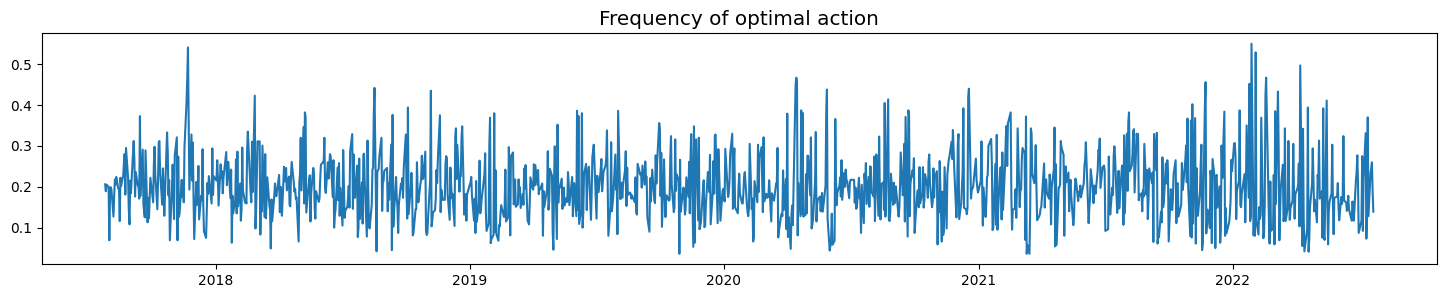

In [10]:
plt.plot(YData_dates[HOLD : YData.shape[0]], optimal_avg)  # noQA E203
plt.title("Frequency of optimal action", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

We now compare how the proposed buys of the algorithm fare in relation to the actual returns of the stocks in this basket. While the strategy performs better than an equal-weighted portfolio that contains the five assets, it fails to track the most significant increases in returns across the sample period.

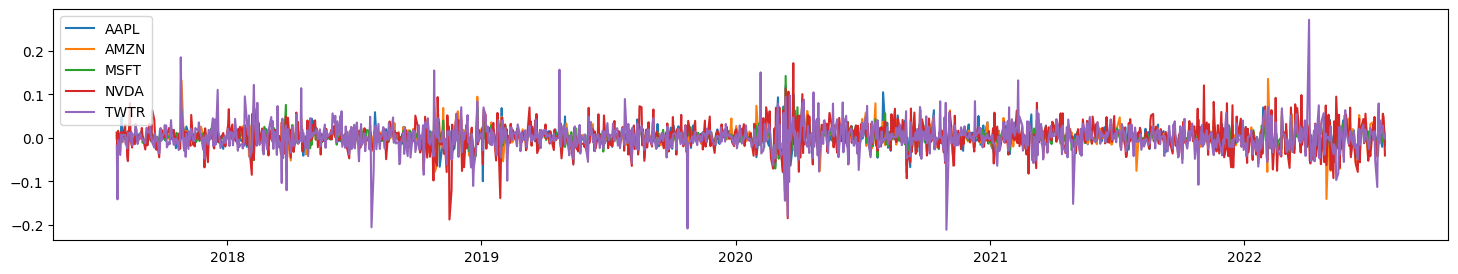

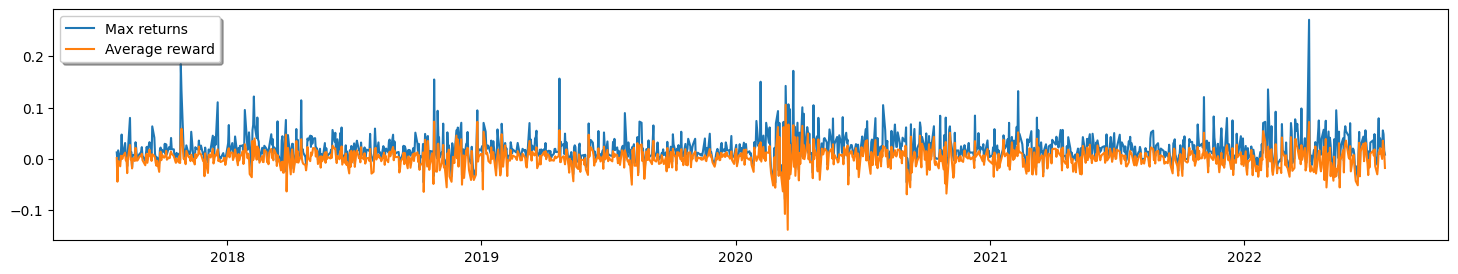

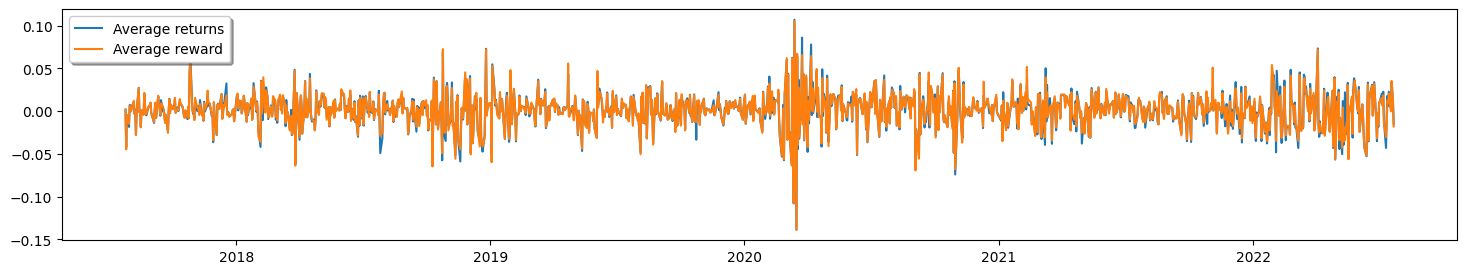

0.20056404136833744
0.36647658654609616 0.31733666056515797
0.4201569942549792 0.30808570039716765


In [11]:
plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :],
)  # noQA E203
plt.legend(tickers)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.max(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.mean(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(np.mean(optimal_avg))
# Average annualized return from holding the equally-weighted portfolio
print(
    (
        1
        + np.mean(
            (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :],
            axis=1,
        )
    ),
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    (1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,
    np.sqrt(250 / HOLD) * np.std(reward_avg),
)

The figure below displays the value over time of initiating with \$1 and investing it either in the bandit strategy or the equally weighted portfolio. Despite the apparent failure to, on average, choose the right action, the "bandit" strategy generates returns above those of the buy-and-hold strategy of the equally weighted portfolio. Thus, when it chooses right, the bandit algorithm tends to generate returns that are high enough to more than compensate for the returns of the equally weighted portfolio.<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

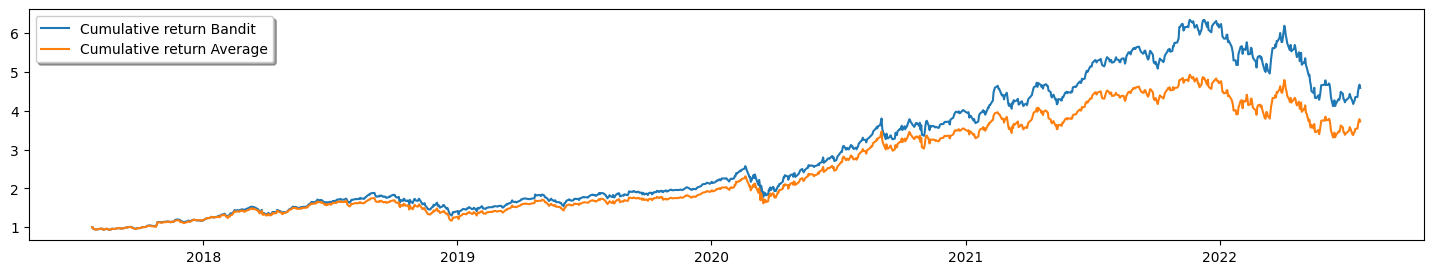

In [12]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData[tt + HOLD - 1, :] - YData[tt - 1, :]) / YData[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

## **3. Conclusion**

In this lesson, we have applied k-bandit to a practical investment case. The results seem promising although more research is needed in order to execute this strategy in real life.

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
